In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd

from pyvbmc import VBMC
import random
import os
from tqdm import tqdm
from trunc_censoring_aborts_utils import rho_A_t_fn, cum_A_t_fn
import corner
import pickle


# data

In [2]:
T_trunc = 0.3
t_stim_0 = 0.2
t_stim_tau = 0.4

In [3]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


# get saved VPs

In [4]:
with open('trunc_and_censor_fit_aborts_LED_0.pkl', 'rb') as f:
    vp_led_off = pickle.load(f)

with open('trunc_and_censor_fit_aborts_LED_1.pkl', 'rb') as f:
    vp_led_on = pickle.load(f)


led_off_samples = vp_led_off.sample(int(1e6))
led_on_samples = vp_led_on.sample(int(1e6))

In [5]:
# LED off 
V_A_off = np.mean(led_off_samples[0][:,0])
theta_A_off = np.mean(led_off_samples[0][:,1])
t_A_aff_off = np.mean(led_off_samples[0][:,2])

# LED on
V_A_on = np.mean(led_on_samples[0][:,0])
theta_A_on = np.mean(led_on_samples[0][:,1])
t_A_aff_on = np.mean(led_on_samples[0][:,2])


# get real data

In [6]:
# data
# off
df_led_off = df[(df['LED_trial'] == 0) & df['timed_fix'].notna() & df['intended_fix'].notna()]
abort_off = df_led_off[ (df_led_off['timed_fix'] < df_led_off['intended_fix']) & \
                            (df_led_off['timed_fix'] > T_trunc) ]['timed_fix'].values



df_led_on = df[ df['LED_trial'] == 1 & df['timed_fix'].notna() & df['intended_fix'].notna() ]
abort_on = df_led_on[ (df_led_on['timed_fix'] < df_led_on['intended_fix']) & \
                            (df_led_on['timed_fix'] > T_trunc) ]['timed_fix'].values

# compare

## pdf funcs

In [7]:
t_stim_0 = 0.2
t_stim_tau = 0.4
def prob_hit_and_fix_survive(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff):
    if t < t_stim_0:
        fix_survive = 1
    else:
        fix_survive = np.exp(-(t - t_stim_0)/t_stim_tau)
    
    return rho_A_t_fn(t-t_A_aff, V_A, theta_A) * fix_survive
    

def pdf_aborts(t, t_stim_0, t_stim_tau, V_A, theta_A, T_trunc, t_A_aff, PDF_trunc_factor):
    """
    pdf of aborts with stim time
    """
    if t < T_trunc:
        return 0

    pdf_hit_and_fix_survive_truncated = prob_hit_and_fix_survive(t, t_stim_0, t_stim_tau, V_A, theta_A, t_A_aff) / PDF_trunc_factor
    return pdf_hit_and_fix_survive_truncated

def did_stim_survive(t, t_stim):
    if t < t_stim:
        return 1
    else:
        return 0
    
def truncated_rho_A_t_fn(t, V_A, theta_A, t_A_aff):
    if t < T_trunc:
        return 0
    else:
        return rho_A_t_fn(t - t_A_aff, V_A, theta_A)


# Only off plot

In [43]:
# data
bin_width = (0.01 + 0.05) / 2
bins = np.arange(T_trunc, 2, bin_width)

hist_off, _ = np.histogram(abort_off, bins=bins, density=True)
hist_off *= len(abort_off)/len(df_led_off)

In [44]:
# theory
# -- theory
t_pts = bins[:-1] + bin_width/2 
# off
pdf_trunc_factor_off = quad(prob_hit_and_fix_survive, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A_off, theta_A_off, t_A_aff_off))[0]
theory_abort_rt_off = np.array([pdf_aborts(t, t_stim_0, t_stim_tau, V_A_off, theta_A_off, T_trunc, t_A_aff_off, pdf_trunc_factor_off) for t in t_pts])



# frac of aborts
t_stim_data = df['intended_fix'].values
trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_off, V_A_off, theta_A_off)

non_aborts_for_all_stim = np.zeros((len(t_stim_data)))
theory_pdf_hit_for_each_t_stim = np.zeros((len(t_stim_data), len(t_pts)))

for idx, t_stim in enumerate(t_stim_data):
    censored_likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff_off, V_A_off, theta_A_off)) / trunc_factor
    not_censored_likelihood = 1 - censored_likelihood
    non_aborts_for_all_stim[idx] = not_censored_likelihood


    pdf_hit = [did_stim_survive(t, t_stim)*(truncated_rho_A_t_fn(t, V_A_off, theta_A_off, t_A_aff_off)/pdf_trunc_factor_off) for t in t_pts]
    theory_pdf_hit_for_each_t_stim[idx, :] = pdf_hit


theory_frac_aborts_off = np.mean(non_aborts_for_all_stim)
theory_pdf_hit_off_each_stim_calc = np.mean(theory_pdf_hit_for_each_t_stim, axis=0)

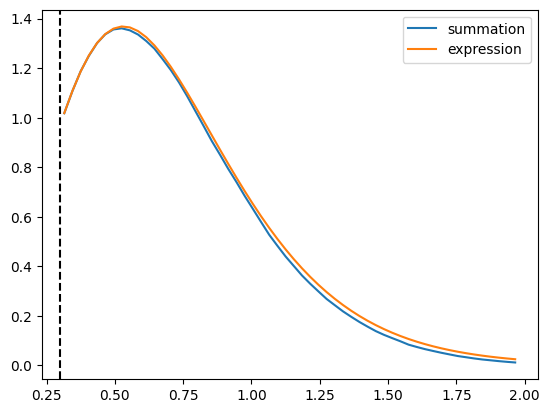

In [45]:
# check the calcu by summation and expression are matching
plt.plot(t_pts, theory_pdf_hit_off_each_stim_calc, label='summation')
plt.plot(t_pts, theory_abort_rt_off, label='expression')
plt.axvline(x=T_trunc, color='k', linestyle='--')
plt.legend()


In [46]:
print(f'theory frac aborts: {theory_frac_aborts_off:.2f}, data frac of aborts : {len(abort_off)/len(df_led_off):.2f}')

theory frac aborts: 0.13, data frac of aborts : 0.13


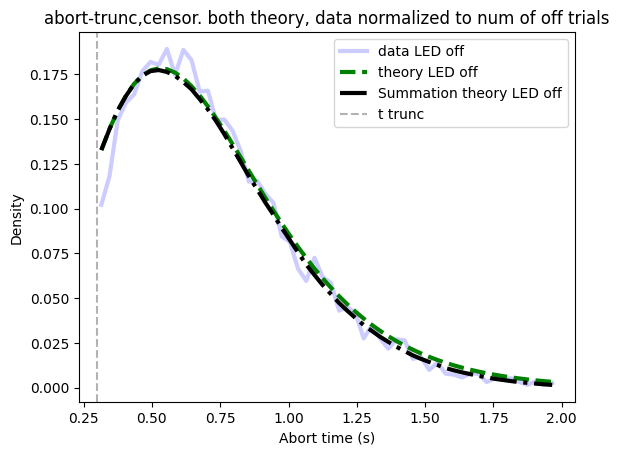

In [47]:
plt.plot(t_pts, hist_off, label='data LED off', color='b', lw=3,alpha=0.2)


plt.plot(t_pts, theory_abort_rt_off*theory_frac_aborts_off, label='theory LED off', color='g', linestyle='--', lw=3)
plt.plot(t_pts, theory_pdf_hit_off_each_stim_calc*theory_frac_aborts_off, label='Summation theory LED off', color='k', linestyle='-.', lw=3)

plt.xlabel('Abort time (s)')
plt.ylabel('Density')
plt.axvline(x=T_trunc, color='k', linestyle='--', alpha=0.3, label='t trunc')

plt.legend()
plt.title('abort-trunc,censor. both theory, data normalized to num of off trials');

## plot

In [13]:
# data
bin_width = 0.05
bins = np.arange(0, 2, bin_width)

hist_off, _ = np.histogram(abort_off, bins=bins, density=True)
hist_off *= len(abort_off)/len(df_led_off)

hist_on, _ = np.histogram(abort_on, bins=bins, density=True)
hist_on *= len(abort_on)/len(df_led_on)


In [14]:
# -- theory
t_pts = bins[:-1] + bin_width/2 
# off
pdf_trunc_factor_off = quad(prob_hit_and_fix_survive, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A_off, theta_A_off, t_A_aff_off))[0]
theory_abort_rt_off = np.array([pdf_aborts(t, t_stim_0, t_stim_tau, V_A_off, theta_A_off, T_trunc, t_A_aff_off, pdf_trunc_factor_off) for t in t_pts])

# on
pdf_trunc_factor_on = quad(prob_hit_and_fix_survive, T_trunc, 10, args=(t_stim_0, t_stim_tau, V_A_on, theta_A_on, t_A_aff_on))[0]
theory_abort_rt_on = np.array([pdf_aborts(t, t_stim_0, t_stim_tau, V_A_on, theta_A_on, T_trunc, t_A_aff_on, pdf_trunc_factor_on) for t in t_pts])


In [15]:
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(t_pts, hist_off, label='LED off', color='b')
# plt.plot(t_pts, hist_on, label='LED on', color='r')
# plt.xlabel('Abort time (s)')
# plt.ylabel('Density')
# plt.legend()
# plt.title('DATA - Abort time normalzied to num of off and on trials');

# plt.subplot(1, 2, 2)
# plt.plot(t_pts, theory_abort_rt_off, label='LED off theory', color='b', linestyle='--')
# plt.plot(t_pts, theory_abort_rt_on, label='LED on theory', color='r', linestyle='--')
# plt.xlabel('Abort time (s)')
# plt.ylabel('Density')
# plt.legend()
# plt.title('THEORY');

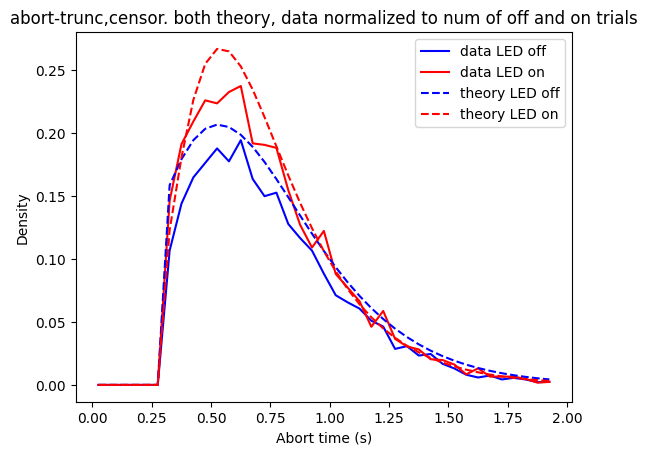

In [16]:
plt.plot(t_pts, hist_off, label='data LED off', color='b')
plt.plot(t_pts, hist_on, label='data LED on', color='r')

theory_frac_of_aborts_off = quad(prob_hit_and_fix_survive, 0, np.inf, args=(t_stim_0, t_stim_tau, V_A_off, theta_A_off, t_A_aff_off))[0]
theory_frac_of_aborts_on = quad(prob_hit_and_fix_survive, 0, np.inf, args=(t_stim_0, t_stim_tau, V_A_on, theta_A_on, t_A_aff_on))[0]

plt.plot(t_pts, theory_abort_rt_off*theory_frac_of_aborts_off, label='theory LED off', color='b', linestyle='--')
plt.plot(t_pts, theory_abort_rt_on*theory_frac_of_aborts_on, label='theory LED on', color='r', linestyle='--')

plt.xlabel('Abort time (s)')
plt.ylabel('Density')
plt.legend()
plt.title('abort-trunc,censor. both theory, data normalized to num of off and on trials');

# the norm term is frac of aborts?

In [17]:
(len(abort_off)/len(df_led_off)), quad(prob_hit_and_fix_survive, T_trunc, np.inf, args=(t_stim_0, t_stim_tau, V_A_off, theta_A_off, t_A_aff_off))[0]

(0.1266135421035463, 0.13407084192379498)

In [18]:
len(abort_on)/len(df_led_on), quad(prob_hit_and_fix_survive, 0, np.inf, args=(t_stim_0, t_stim_tau, V_A_on, theta_A_on, t_A_aff_on))[0]

(0.15463299037105918, 0.16474453084011115)

# check with 1 - censored likelihood and t_stim

## off

In [19]:
t_stim_data = df['intended_fix'].values
trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_off, V_A_off, theta_A_off)
non_aborts_for_all_stim = np.zeros((len(t_stim_data)))
for idx, t_stim in enumerate(t_stim_data):
    censored_likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff_off, V_A_off, theta_A_off)) / trunc_factor
    not_censored_likelihood = 1 - censored_likelihood

    non_aborts_for_all_stim[idx] = not_censored_likelihood


In [20]:
np.mean(non_aborts_for_all_stim), (len(abort_off)/len(df_led_off))

(np.float64(0.130390786292428), 0.1266135421035463)

## on

In [21]:
t_stim_data = df['intended_fix'].values
trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff_on, V_A_on, theta_A_on)
non_aborts_for_all_stim = np.zeros((len(t_stim_data)))
for idx, t_stim in enumerate(t_stim_data):
    censored_likelihood = (1 - cum_A_t_fn(t_stim - t_A_aff_on, V_A_on, theta_A_on)) / trunc_factor
    not_censored_likelihood = 1 - censored_likelihood

    non_aborts_for_all_stim[idx] = not_censored_likelihood


In [22]:
np.mean(non_aborts_for_all_stim), (len(abort_on)/len(df_led_on))

(np.float64(0.1558904867953234), 0.15463299037105918)